<a href="https://colab.research.google.com/github/vipashaaV321/User-Intent-Modeling/blob/main/lstm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directional

## 0.5

Seed item: 283
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3371 - accuracy: 0.4172 - val_loss: 1.2590 - val_accuracy: 0.4419
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2348 - accuracy: 0.4556 - val_loss: 1.2565 - val_accuracy: 0.4448
Epoch 3/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2188 - accuracy: 0.4630 - val_loss: 1.2602 - val_accuracy: 0.4448
Epoch 4/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2105 - accuracy: 0.4674 - val_loss: 1.2690 - val_accuracy: 0.4345
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2056 - accuracy: 0.4686 - val_loss: 1.2675 - val_accuracy: 0.4405
Epoch 6/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2013 - accuracy: 0.4703 - val_loss: 1.2694 - val_accuracy: 0.4374
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.1979 - accuracy: 0.4734 - val_loss: 1.266

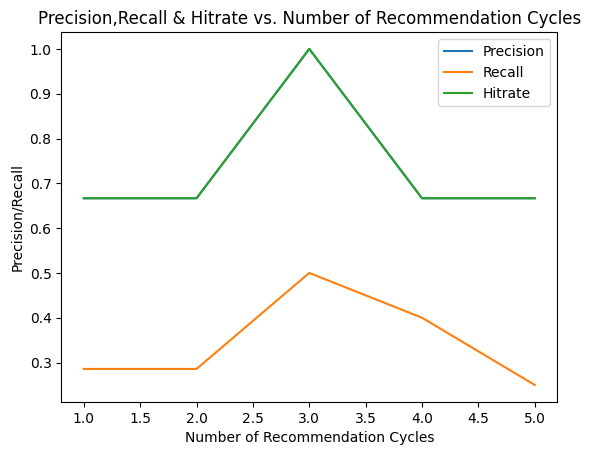

0.7333330888889703
0.34428565904252606
0.7333333333333332


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.5) * overlap + 0.5 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 0

Seed item: 380
Epoch 1/10
2500/2500 [==============================] - 15s 6ms/step - loss: 1.3343 - accuracy: 0.4184 - val_loss: 1.2612 - val_accuracy: 0.4441
Epoch 2/10
2500/2500 [==============================] - 12s 5ms/step - loss: 1.2354 - accuracy: 0.4550 - val_loss: 1.2598 - val_accuracy: 0.4444
Epoch 3/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2194 - accuracy: 0.4617 - val_loss: 1.2642 - val_accuracy: 0.4410
Epoch 4/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2114 - accuracy: 0.4662 - val_loss: 1.2623 - val_accuracy: 0.4414
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2059 - accuracy: 0.4697 - val_loss: 1.2675 - val_accuracy: 0.4374
Epoch 6/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2021 - accuracy: 0.4723 - val_loss: 1.2665 - val_accuracy: 0.4394
Epoch 7/10
2500/2500 [==============================] - 14s 6ms/step - loss: 1.1985 - accuracy: 0.4721 - val_loss: 1.26

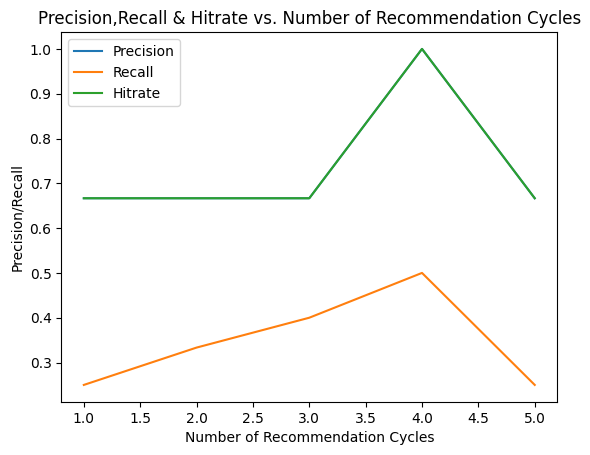

0.7333330888889703
0.34666661038889823
0.7333333333333333


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0) * overlap + 0 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 0.25

Seed item: 380
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3352 - accuracy: 0.4178 - val_loss: 1.2620 - val_accuracy: 0.4356
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2351 - accuracy: 0.4546 - val_loss: 1.2592 - val_accuracy: 0.4412
Epoch 3/10
2500/2500 [==============================] - 9s 3ms/step - loss: 1.2195 - accuracy: 0.4615 - val_loss: 1.2599 - val_accuracy: 0.4443
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2109 - accuracy: 0.4676 - val_loss: 1.2628 - val_accuracy: 0.4419
Epoch 5/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2054 - accuracy: 0.4697 - val_loss: 1.2659 - val_accuracy: 0.4395
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2016 - accuracy: 0.4720 - val_loss: 1.2655 - val_accuracy: 0.4399
Epoch 7/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1986 - accuracy: 0.4742 - val_loss: 1.

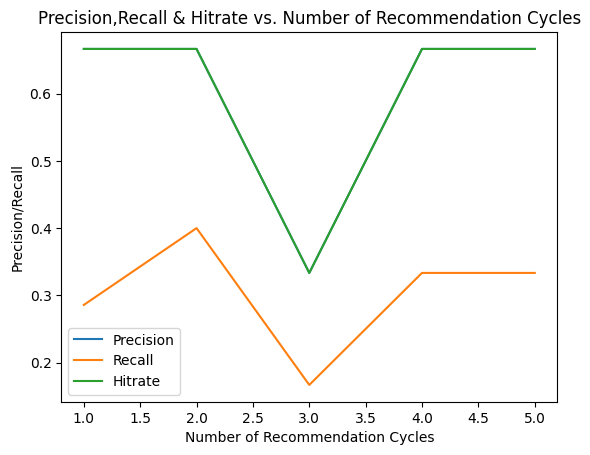

0.5999998000000668
0.3038094718684897
0.5999999999999999


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.25) * overlap + 0.25 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 0.75

Seed item: 433
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3354 - accuracy: 0.4197 - val_loss: 1.2621 - val_accuracy: 0.4438
Epoch 2/10
2500/2500 [==============================] - 11s 5ms/step - loss: 1.2338 - accuracy: 0.4541 - val_loss: 1.2588 - val_accuracy: 0.4408
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2185 - accuracy: 0.4633 - val_loss: 1.2605 - val_accuracy: 0.4423
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2099 - accuracy: 0.4669 - val_loss: 1.2647 - val_accuracy: 0.4397
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2048 - accuracy: 0.4695 - val_loss: 1.2634 - val_accuracy: 0.4390
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2008 - accuracy: 0.4705 - val_loss: 1.2690 - val_accuracy: 0.4414
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1975 - accuracy: 0.4726 - val_loss: 1.2

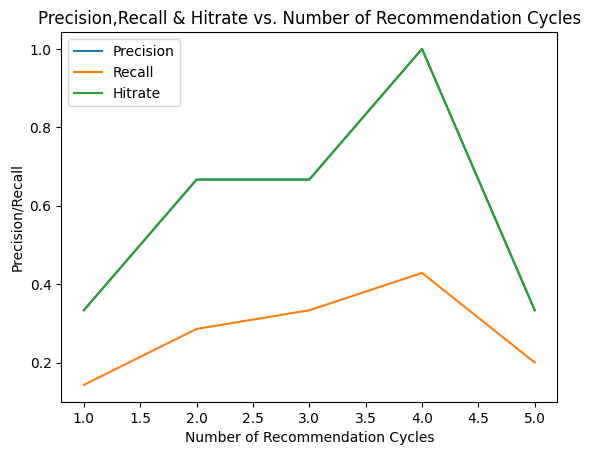

0.5999998000000667
0.278095194494338
0.6


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.75) * overlap + 0.75 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 1

Seed item: 433
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3360 - accuracy: 0.4198 - val_loss: 1.2594 - val_accuracy: 0.4410
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2357 - accuracy: 0.4531 - val_loss: 1.2559 - val_accuracy: 0.4421
Epoch 3/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2194 - accuracy: 0.4614 - val_loss: 1.2605 - val_accuracy: 0.4409
Epoch 4/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2108 - accuracy: 0.4670 - val_loss: 1.2640 - val_accuracy: 0.4376
Epoch 5/10
2500/2500 [==============================] - 14s 6ms/step - loss: 1.2055 - accuracy: 0.4685 - val_loss: 1.2675 - val_accuracy: 0.4379
Epoch 6/10
2500/2500 [==============================] - 14s 6ms/step - loss: 1.2015 - accuracy: 0.4712 - val_loss: 1.2662 - val_accuracy: 0.4367
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.1981 - accuracy: 0.4715 - val_loss: 1.

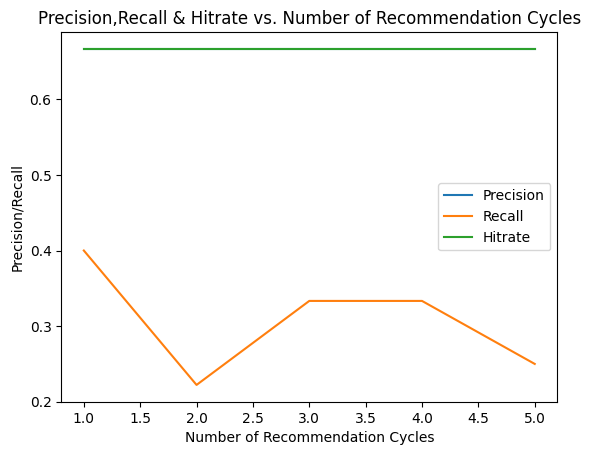

0.6666664444445185
0.30777772836729217
0.6666666666666666


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Directional')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Directional')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 1) * overlap + 1 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


# SMEAN

## 0.5

Seed item: 7
Epoch 1/10
2500/2500 [==============================] - 18s 7ms/step - loss: 1.3331 - accuracy: 0.4196 - val_loss: 1.2589 - val_accuracy: 0.4448
Epoch 2/10
2500/2500 [==============================] - 16s 6ms/step - loss: 1.2363 - accuracy: 0.4537 - val_loss: 1.2561 - val_accuracy: 0.4419
Epoch 3/10
2500/2500 [==============================] - 18s 7ms/step - loss: 1.2199 - accuracy: 0.4612 - val_loss: 1.2597 - val_accuracy: 0.4399
Epoch 4/10
2500/2500 [==============================] - 14s 6ms/step - loss: 1.2117 - accuracy: 0.4669 - val_loss: 1.2612 - val_accuracy: 0.4424
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2059 - accuracy: 0.4704 - val_loss: 1.2633 - val_accuracy: 0.4427
Epoch 6/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2017 - accuracy: 0.4716 - val_loss: 1.2676 - val_accuracy: 0.4403
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1986 - accuracy: 0.4710 - val_loss: 1.27

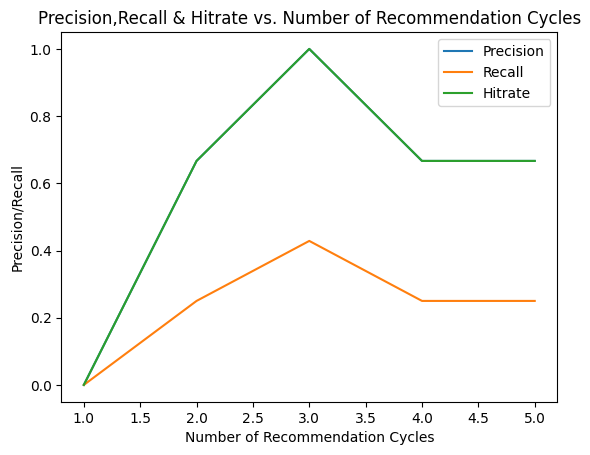

0.5999998000000668
0.23571425471939186
0.5999999999999999


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.5) * overlap + 0.5 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 0

Seed item: 713
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3379 - accuracy: 0.4175 - val_loss: 1.2589 - val_accuracy: 0.4439
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2342 - accuracy: 0.4554 - val_loss: 1.2577 - val_accuracy: 0.4428
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2184 - accuracy: 0.4628 - val_loss: 1.2601 - val_accuracy: 0.4405
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2101 - accuracy: 0.4671 - val_loss: 1.2639 - val_accuracy: 0.4373
Epoch 5/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2053 - accuracy: 0.4682 - val_loss: 1.2660 - val_accuracy: 0.4403
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2010 - accuracy: 0.4715 - val_loss: 1.2665 - val_accuracy: 0.4430
Epoch 7/10
2500/2500 [==============================] - 9s 3ms/step - loss: 1.1978 - accuracy: 0.4724 - val_loss: 1.27

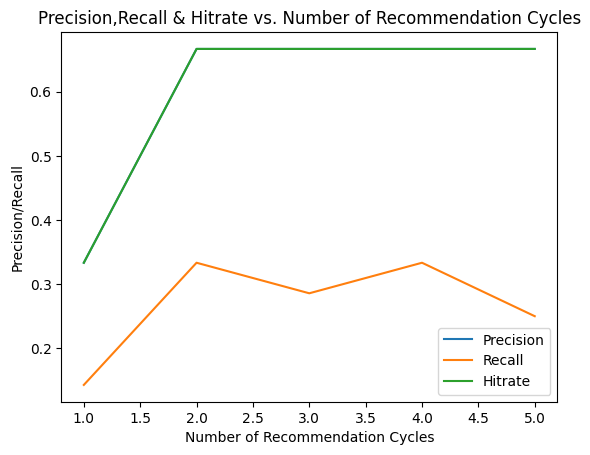

0.5999998000000668
0.2690475783305051
0.5999999999999999


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0) * overlap + 0 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 0.25

Seed item: 275
Epoch 1/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3357 - accuracy: 0.4168 - val_loss: 1.2602 - val_accuracy: 0.4433
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2344 - accuracy: 0.4543 - val_loss: 1.2583 - val_accuracy: 0.4408
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2185 - accuracy: 0.4642 - val_loss: 1.2605 - val_accuracy: 0.4424
Epoch 4/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2104 - accuracy: 0.4677 - val_loss: 1.2653 - val_accuracy: 0.4401
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2049 - accuracy: 0.4680 - val_loss: 1.2676 - val_accuracy: 0.4365
Epoch 6/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2008 - accuracy: 0.4730 - val_loss: 1.2671 - val_accuracy: 0.4408
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.1980 - accuracy: 0.4717 - val_loss: 1.2650

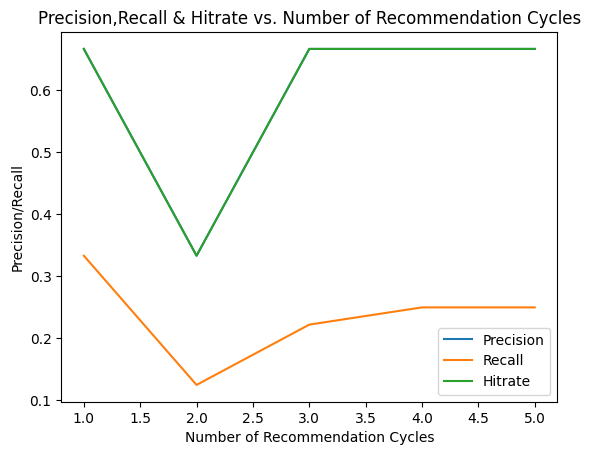

0.5999998000000668
0.2361110794367328
0.5999999999999999


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.25) * overlap + 0.25 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 0.75

Seed item: 433
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3354 - accuracy: 0.4197 - val_loss: 1.2621 - val_accuracy: 0.4438
Epoch 2/10
2500/2500 [==============================] - 11s 5ms/step - loss: 1.2338 - accuracy: 0.4541 - val_loss: 1.2588 - val_accuracy: 0.4408
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2185 - accuracy: 0.4633 - val_loss: 1.2605 - val_accuracy: 0.4423
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2099 - accuracy: 0.4669 - val_loss: 1.2647 - val_accuracy: 0.4397
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2048 - accuracy: 0.4695 - val_loss: 1.2634 - val_accuracy: 0.4390
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2008 - accuracy: 0.4705 - val_loss: 1.2690 - val_accuracy: 0.4414
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1975 - accuracy: 0.4726 - val_loss: 1.2

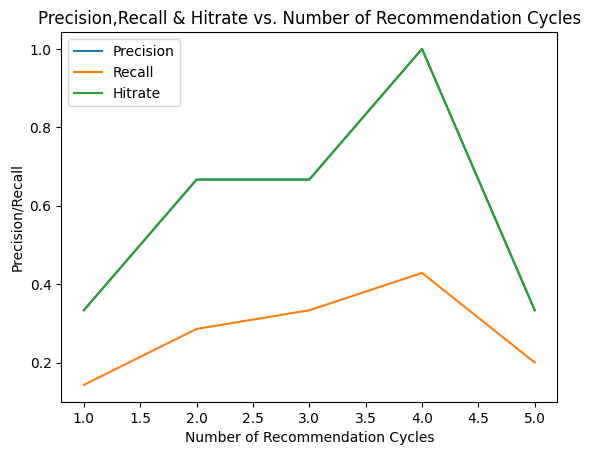

0.5999998000000667
0.278095194494338
0.6


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 0.75) * overlap + 0.75 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


## 1

Seed item: 7
Epoch 1/10
2500/2500 [==============================] - 9s 3ms/step - loss: 1.3387 - accuracy: 0.4180 - val_loss: 1.2615 - val_accuracy: 0.4419
Epoch 2/10
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2343 - accuracy: 0.4542 - val_loss: 1.2568 - val_accuracy: 0.4466
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2188 - accuracy: 0.4620 - val_loss: 1.2616 - val_accuracy: 0.4378
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2110 - accuracy: 0.4679 - val_loss: 1.2624 - val_accuracy: 0.4395
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2059 - accuracy: 0.4697 - val_loss: 1.2667 - val_accuracy: 0.4405
Epoch 6/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2015 - accuracy: 0.4708 - val_loss: 1.2711 - val_accuracy: 0.4376
Epoch 7/10
2500/2500 [==============================] - 9s 3ms/step - loss: 1.1988 - accuracy: 0.4729 - val_loss: 1.2695 - 

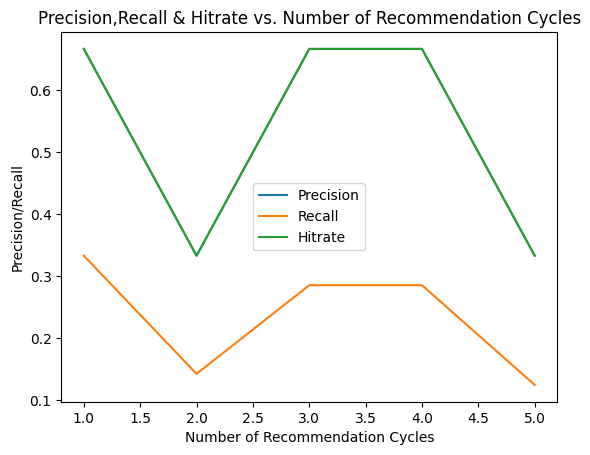

0.5333331555556149
0.2345237748795403
0.5333333333333333


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 1) * overlap + 1 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items


    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22

      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations

            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)

        return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)

    # Evaluate recommendation quality
    precision_list, recall_list, hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)

    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)

if __name__ == '__main__':
    main()


# final

Seed item: 8
Epoch 1/10
2500/2500 [==============================] - 10s 3ms/step - loss: 1.3360 - accuracy: 0.4167 - val_loss: 1.2602 - val_accuracy: 0.4390
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2349 - accuracy: 0.4534 - val_loss: 1.2584 - val_accuracy: 0.4429
Epoch 3/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.2196 - accuracy: 0.4609 - val_loss: 1.2615 - val_accuracy: 0.4396
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2105 - accuracy: 0.4668 - val_loss: 1.2635 - val_accuracy: 0.4423
Epoch 5/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.2057 - accuracy: 0.4697 - val_loss: 1.2668 - val_accuracy: 0.4384
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 1.2015 - accuracy: 0.4706 - val_loss: 1.2635 - val_accuracy: 0.4401
Epoch 7/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.1983 - accuracy: 0.4732 - val_loss: 1.2704 -

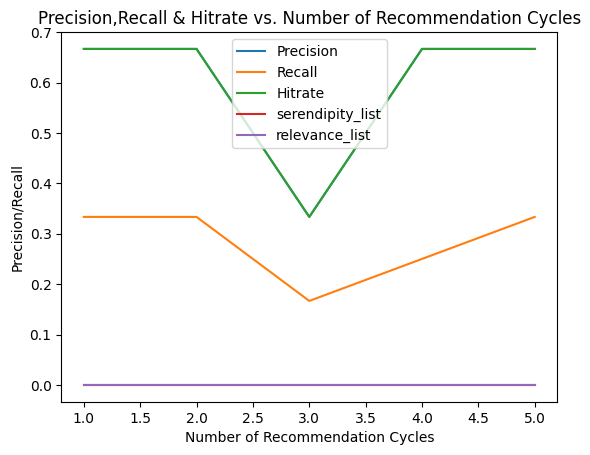

0.5999998000000668
0.28333328819445175
0.5999999999999999
[0.0, 0.0, 0.0, 0.0, 0.0] serendipty
[0.0, 0.0, 0.0, 0.0, 0.0] relevance


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ndcg_score, precision_score, recall_score
from sklearn.model_selection import train_test_split





class RecommenderLSTM:
    def __init__(self, num_users, num_items, embedding_dim):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

    def build_model(self):
        user_input = keras.Input(shape=(1,))
        item_input = keras.Input(shape=(1,))

        user_embedding = keras.layers.Embedding(self.num_users, self.embedding_dim)(user_input)
        item_embedding = keras.layers.Embedding(self.num_items, self.embedding_dim)(item_input)

        user_embedding = keras.layers.Flatten()(user_embedding)
        item_embedding = keras.layers.Flatten()(item_embedding)

        merged = keras.layers.Concatenate()([user_embedding, item_embedding])
        rnn_output = keras.layers.Dense(self.embedding_dim)(merged)
        output = keras.layers.Dense(10, activation='softmax')(rnn_output)

        model = keras.Model(inputs=[user_input, item_input], outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train(self, train_data, epochs, batch_size):
        user_ids = train_data['user_id'].values - 1
        item_ids = train_data['item_id'].values - 1
        ratings = train_data['rating'].values

        user_train, user_val, item_train, item_val, rating_train, rating_val = train_test_split(
            user_ids, item_ids, ratings, test_size=0.2, random_state=42
        )
        train_labels_onehot = to_categorical(rating_train, num_classes=10)
        val_labels_onehot = to_categorical(rating_val, num_classes=10)

        model = self.build_model()

        model.fit([user_train, item_train], train_labels_onehot, epochs=epochs, batch_size=batch_size,
                  validation_data=([user_val, item_val],  val_labels_onehot))

        return model

    def recommend(self, user_id, model, top_n):
        user_ids = np.full(self.num_items, user_id - 1)
        item_ids = np.arange(self.num_items)

        predictions = model.predict([user_ids, item_ids]).flatten()

        top_indices = np.argsort(predictions)[::-1][:top_n]
        top_items = top_indices + 1  # Add 1 to adjust for 0-based indexing

        return top_items

class RecommenderSystem:
    def __init__(self, num_users, num_items):
        self.user_item_matrix = np.zeros((num_users, num_items))
        self.weights = np.zeros(num_items)
        self.user_preferences = np.zeros(num_items)

    def train(self, train_data, seed_item):
        for _, row in train_data.iterrows():
            user = row['user_id'] - 1
            item = row['item_id'] - 1
            rating = row['rating']
            self.user_item_matrix[user, item] = rating

        self.reweight(seed_item, [], 'Similarity-Mean')

    def update_user_preferences(self, user, item, rating):
        self.user_preferences[item] = rating
        self.reweight(item, [], 'Similarity-Mean')  # Update weights based on the new preference

    def recommend(self, seed_item, candidate_items, n):
        scores = np.zeros(len(candidate_items))

        for i, item in enumerate(candidate_items):
            overlap = self.calculate_overlap(seed_item, item)
            scores[i] = (1 - 1) * overlap + 1 * (overlap / len(candidate_items))

        sorted_indices = np.argsort(scores)[::-1]
        recommendations = [candidate_items[idx] for idx in sorted_indices[:n]]
        return recommendations

    def update_weights(self, seed_item, rejected_items, reweighting_policy):
        for item in rejected_items:
            if reweighting_policy == 'Directional':
                self.weights[item] += self.calculate_directional_delta(seed_item, item)
            elif reweighting_policy == 'Similarity':
                self.weights[item] += self.calculate_similarity_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Mean':
                self.weights[item] += self.calculate_similarity_mean_delta(seed_item, item)
            elif reweighting_policy == 'Similarity-Max':
                self.weights[item] += self.calculate_similarity_max_delta(seed_item, item)
            elif reweighting_policy == 'Recency':
                self.weights[item] += self.calculate_recency_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Mean':
                self.weights[item] += self.calculate_recency_mean_delta(seed_item, item, len(rejected_items))
            elif reweighting_policy == 'Recency-Max':
                self.weights[item] += self.calculate_recency_max_delta(seed_item, item, len(rejected_items))

    def calculate_overlap(self, item1, item2):
        return np.dot(self.user_item_matrix[:, item1], self.user_item_matrix[:, item2])

    def calculate_directional_delta(self, seed_item, item):
        return self.calculate_overlap(seed_item, item)

    def calculate_similarity_delta(self, seed_item, item):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity * self.calculate_overlap(seed_item, item)

    def calculate_similarity_mean_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - mean_similarity

    def calculate_similarity_max_delta(self, seed_item, item):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) * similarities[item]) - max_similarity

    def calculate_recency_delta(self, seed_item, item, depth):
        similarity = self.calculate_overlap(seed_item, item) / (self.calculate_overlap(item, item) + 1e-6)
        return similarity / depth - self.calculate_overlap(item, item)

    def calculate_recency_mean_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        mean_similarity = np.mean(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - mean_similarity

    def calculate_recency_max_delta(self, seed_item, item, depth):
        similarities = [
            self.calculate_overlap(item, j) / (self.calculate_overlap(j, j) + 1e-6)
            for j in range(self.user_item_matrix.shape[1])
        ]
        max_similarity = np.max(similarities)
        return (self.calculate_overlap(seed_item, item) / depth) - max_similarity

    def reweight(self, seed_item, rejected_items, reweighting_policy):
        self.update_weights(seed_item, rejected_items, reweighting_policy)

    def generate_user_profile(self, user_id):
        user_ratings = self.user_item_matrix[user_id]
        liked_items = np.where(user_ratings > 3)[0]
        disliked_items = np.where(user_ratings < 3)[0]
        return liked_items, disliked_items
    def calculate_serendipity(self, seed_item, recommended_items):
        seed_preferences = self.user_preferences[seed_item]
        relevant_preferences = []

        for item in recommended_items:
          if item < len(self.user_preferences):
            recommended_preferences = self.user_preferences[item]
            relevant_preferences.append(recommended_preferences)

        if relevant_preferences:
          serendipity = np.mean(relevant_preferences) - seed_preferences
        else:
        # Handle the case when there are no relevant preferences
          serendipity = 0.0

        return serendipity

    def calculate_relevance(self, seed_item, recommended_items):
        seed_preferences = self.user_preferences[seed_item]
        relevant_preferences = []

        for item in recommended_items:
          if item in self.user_preferences:
            recommended_preferences = self.user_preferences[item]
            relevant_preferences.append(recommended_preferences)

        if relevant_preferences:
          relevance = np.mean(relevant_preferences) - seed_preferences
        else:
        # Handle the case when there are no relevant preferences
          relevance = 0.0

        return relevance

    def generate_recommendations(self, user_id, num_recommendation_cycles, num_recommendations):
      liked_items, disliked_items = self.generate_user_profile(user_id)
      seed_item = np.random.choice(liked_items)
      print(f"Seed item: {seed_item + 1}")

      data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
      columns = ['user_id', 'item_id', 'rating', 'timestamp']
      train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)

      # Define parameters
      num_users = train_data['user_id'].nunique()
      num_items = train_data['item_id'].nunique()
      embedding_dim = 32
      epochs = 10
      batch_size = 32
      num_recommendation_cycles = 5
      num_recommendations = 3
      selected_user_id = 22
      serendipity_list = []
      relevance_list = []
      # Create and train the recommender LSTM
      recommender_lstm = RecommenderLSTM(num_users, num_items, embedding_dim)
      model = recommender_lstm.train(train_data, epochs, batch_size)

      # Generate recommendations for a specific user
      recommended_items = []
      for cycle in range(num_recommendation_cycles):
          recommendations = recommender_lstm.recommend(selected_user_id, model, num_recommendations)
          # print(f"Cycle {cycle + 1} Recommendations: {recommendations}")
          recommended_items.extend(recommendations)
          # Calculate serendipity and relevance
          serendipity = self.calculate_serendipity(seed_item, recommendations)
          relevance = self.calculate_relevance(seed_item, recommendations)

          serendipity_list.append(serendipity)
          relevance_list.append(relevance)
          # Update user preferences and retrain the model if needed
          # ...

      recommended_items = recommended_items[:num_recommendation_cycles * num_recommendations]
      return recommended_items,serendipity_list, relevance_list



    def evaluate_recommendation_quality(self, test_data, user_id, num_recommendation_cycles, num_recommendations):
        precision_list = []
        recall_list = []
        hitrate_list = []

        for _ in range(num_recommendation_cycles):
            liked_items, _ = self.generate_user_profile(user_id)
            seed_item = np.random.choice(liked_items)

            relevant_items = []

            for _ in range(num_recommendation_cycles):
                candidate_items = np.setdiff1d(liked_items, [seed_item])
                recommendations = self.recommend(seed_item, candidate_items, num_recommendations)
                relevant_items.extend(recommendations)
                seed_item = np.random.choice(np.setdiff1d(candidate_items, recommendations))

            relevant_items = list(set(relevant_items))
            recommended_items = self.recommend(seed_item, liked_items, num_recommendations)

            true_positives = len(set(recommended_items).intersection(relevant_items))
            false_positives = len(recommended_items) - true_positives
            false_negatives = len(relevant_items) - true_positives

            precision = true_positives / (true_positives + false_positives + 1e-6)
            recall = true_positives / (true_positives + false_negatives + 1e-6)
            hitrate = true_positives / num_recommendations



            precision_list.append(precision)
            recall_list.append(recall)
            hitrate_list.append(hitrate)
            effectiveness = sum(precision_list) / num_recommendation_cycles
            satisfaction = sum(recall_list) / num_recommendation_cycles

        return precision_list, recall_list, effectiveness, satisfaction,hitrate_list
        # return precision_list, recall_list, hitrate_list

# Example usage
def main():
    # Load data


    data_path = '/content/drive/MyDrive/Data/movie-lens/u.data'
    columns = ['user_id', 'item_id', 'rating', 'timestamp']
    train_data = pd.read_csv(data_path, sep='\t', names=columns, header=None)
    test_data= train_data.sample(frac=0.2, random_state=42) # Sample test data



    # Define parameters
    num_users = train_data['user_id'].nunique()
    num_items = train_data['item_id'].nunique()
    num_recommendation_cycles = 5
    num_recommendations = 3

    # Create and train the recommender system
    recommender = RecommenderSystem(num_users, num_items)
    recommender.train(train_data, seed_item=1)

    # Generate recommendations for a specific user
    user_id = 22
    recommended_items,serendipity_list, relevance_list=recommender.generate_recommendations(user_id, num_recommendation_cycles, num_recommendations)
    print(recommended_items,serendipity_list, relevance_list)
    # Evaluate recommendation quality
    precision_list, recall_list, effectiveness, satisfaction,hitrate_list = recommender.evaluate_recommendation_quality(test_data, user_id,
                                                                              num_recommendation_cycles,
                                                                              num_recommendations)
    print(satisfaction,hitrate_list)
    # Print precision and recall for each cycle
    for i in range(num_recommendation_cycles):
        print(f"Cycle {i + 1} - Precision: {precision_list[i]}, Recall: {recall_list[i]}, Hit Rate: {hitrate_list[i]}")

    # Plot graph for number of recommendations cycle and precision/recall
    plt.plot(range(1, num_recommendation_cycles + 1), precision_list, label='Precision')
    plt.plot(range(1, num_recommendation_cycles + 1), recall_list, label='Recall')
    plt.plot(range(1, num_recommendation_cycles + 1), hitrate_list, label='Hitrate')
    plt.plot(range(1, num_recommendation_cycles + 1), serendipity_list, label='serendipity_list')
    plt.plot(range(1, num_recommendation_cycles + 1), relevance_list, label='relevance_list')


    plt.xlabel('Number of Recommendation Cycles')
    plt.ylabel('Precision/Recall')
    plt.title('Precision,Recall & Hitrate vs. Number of Recommendation Cycles')
    plt.legend()
    plt.show()
    print(sum(precision_list)/5)
    print(sum(recall_list)/5)
    print(sum(hitrate_list) / 5)
    print(serendipity_list,"serendipty")
    print(relevance_list,"relevance")

if __name__ == '__main__':
    main()
